# Seasonal Cycle

Niki Gruber suggests that the seasonal cycle is investigated more. Here I'll take each mean seasonal cycle and decompose it into the thermal and non-thermal component. I'll also do this for the Landschuetzer data to see how well they compare.

**NOTE**: Landschuetzer product does not include SST out of the box. Will just start with doing it on the model output.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
plt.style.use('ocn-clim')

## Load in Data

In [2]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any 
    inputted variable and returns an xarray dataset for the forced signal, 
    residuals, and the total time series
    """
    fileDir = ('/glade/p_old/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' 
               + EBU + '/filtered_output/')
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR 
                                    + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' 
                                       + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR 
                                    + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' 
                                       + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    if AW == True:
        return ds_forced[VAR + '_AW'], ds_residuals[VAR + '_AW'], \
               ds_total[VAR + '_AW']
    else:
        return ds_forced[VAR], ds_residuals[VAR], ds_total[VAR]
                         

In [3]:
def load_in_landschuetzer(VAR, EBU):
    """
    Loads in the SOM-FFN pCO2 data from the EBUS of interest. This is from the
    regridded SOM-FFN (to POP grid) and then extracted as with the model output.
    As of now, there is no SST data.
    """
    fileDir = '/glade/work/rbrady/EBUS_BGC_Variability/' + \
              'Landschuetzer_Extracted/' + EBU + \
              '/SOM-FFN.' + VAR + '.' + EBU + '.extracted_AW.1982-2015.nc'
    ds = xr.open_dataset(fileDir)
    return ds[VAR + '_AW']

# CO$_{2}$ Flux
Does pCO2 drive that flux?

In [4]:
EBC = 'CalCS'
cesm_fgco2_mean, _, _ = load_in_filtered_data('FG_CO2', EBC)
cesm_pco2_mean, _, _ = load_in_filtered_data('pCO2SURF', EBC)
cesm_U_mean, _, _ = load_in_filtered_data('U', EBC)

In [5]:
# Detrend
cesm_fgco2 = cesm_fgco2_mean.to_dataset() \
    .apply(et.ufunc.remove_polynomial_fit)['FG_CO2_AW']
cesm_pco2 = cesm_pco2_mean.to_dataset() \
    .apply(et.ufunc.remove_polynomial_fit)['pCO2SURF_AW']
cesm_U_mean = cesm_U_mean**2
cesm_U = cesm_U_mean.to_dataset() \
    .apply(et.ufunc.remove_polynomial_fit)['U_AW']

In [6]:
# 1982-2015 period?
cesm_fgco2 = cesm_fgco2.sel(time=slice('1982-01','2015-12'))
cesm_pco2 = cesm_pco2.sel(time=slice('1982-01','2015-12'))
cesm_U = cesm_U.sel(time=slice('1982-01','2015-12'))

# Compute seasonal cycle
cesm_fgco2 = cesm_fgco2.groupby('time.month').mean('time')
cesm_pco2 = cesm_pco2.groupby('time.month').mean('time')
cesm_U = cesm_U.groupby('time.month').mean('time')

# Normalize
cesm_fgco2 = cesm_fgco2 / cesm_fgco2.std()
cesm_pco2 = cesm_pco2 / cesm_pco2.std()
cesm_U = cesm_U / cesm_U.std()

(-2, 2)

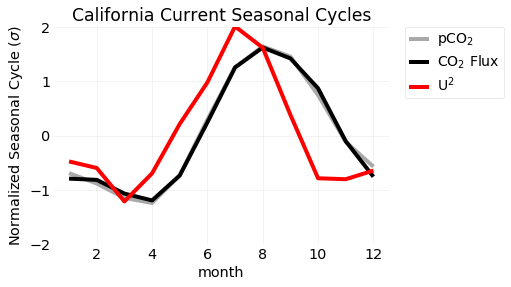

In [7]:
# Plot
title = {'CalCS': 'California Current',
         'HumCS': 'Humboldt Current',
         'CanCS': 'Canary Current',
         'BenCS': 'Benguela Current'}
f, ax = plt.subplots()

cesm_pco2.plot(color='#a9a9a9', linewidth=4, label='pCO$_{2}$')
cesm_fgco2.plot(color='k', linewidth=4, label='CO$_{2}$ Flux')
cesm_U.plot(color='r', linewidth=4, label='U$^{2}$')

ax.set_ylabel('Normalized Seasonal Cycle ($\sigma$)')
ax.set_title(title[EBC] + ' Seasonal Cycles')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.setp(plt.gca().get_legend().get_texts(), fontsize=14)

ax.set_ylim([-2, 2])
#et.vis.savefig(EBC + '_CO2flux_pCO2', extension='.png')

# pCO2 Decomposition

In [42]:
EBC = 'BenCS'
_, _, cesm_sst_total = load_in_filtered_data('SST', EBC)
_, _, cesm_pco2_total = load_in_filtered_data('pCO2SURF', EBC)
som_pco2 = load_in_landschuetzer('spco2_raw', EBC)

In [43]:
ds = xr.merge([cesm_sst_total, cesm_pco2_total])
ds = ds.rename({'SST_AW': 'sst', 'pCO2SURF_AW': 'pCO2'})

In [44]:
# Reduce to cover Landschuetzer period.
ds = ds.mean('ensemble')
ds = ds.sel(time=slice('1982-01', '2015-12'))

## Compute Mean Seasonal Cycle

In [45]:
def takahashi_decomp(ds):
    """
    Performs the temperature/non-temperature decomposition by Takahashi
    and returns the dataset with 'spco2_T' and 'spco2_nonT' added to
    the variable list.
    
    This also detrends the results so you can look at the relative magnitudes.
    """
    ds['pco2_nonT'] = ds.pCO2 * np.exp(0.0423 * (ds.sst.mean() - ds.sst))
    ds['pco2_T'] = ds.pCO2.mean() * np.exp(0.0423 * (ds.sst - ds.sst.mean()))
    return ds

In [46]:
def compute_seasonal_component(ds):
    """
    After doing the Takahashi decomposition, this will compute the 
    seasonal component for a given dataset. 
    """
    # Remove any linear trend over this time period. Moreso for the nonT portion, but
    # also centers around zero for the final vis.
    ds = ds.apply(et.ufunc.remove_polynomial_fit)
    T = ds.pco2_T.groupby('time.month').mean()
    nonT = ds.pco2_nonT.groupby('time.month').mean()
    total = ds.pCO2.groupby('time.month').mean()
    return nonT, T, total

In [47]:
ds = takahashi_decomp(ds)
nonT, T, total = compute_seasonal_component(ds)

In [48]:
som_pco2 = som_pco2.to_dataset().apply(et.ufunc.remove_polynomial_fit) \
    .spco2_raw_AW
som_pco2 = som_pco2.groupby('time.month').mean('time')

# Plot Comparison

In [49]:
def repeat_cycle(da):
    """
    Given a 12-month dataarray, this will create a new 24-month data
    array with repeating components to see the seasonal cycle better.
    """
    da = xr.concat([da, da], dim='month')
    da['month'] = np.arange(1, 25, 1)
    return da

In [50]:
def plot_cycle(da, **kwargs):
    """
    Plot the given seasonal cycle curve (T-component, raw cycle, etc.)
    """
    da = repeat_cycle(da)
    da.plot(**kwargs)

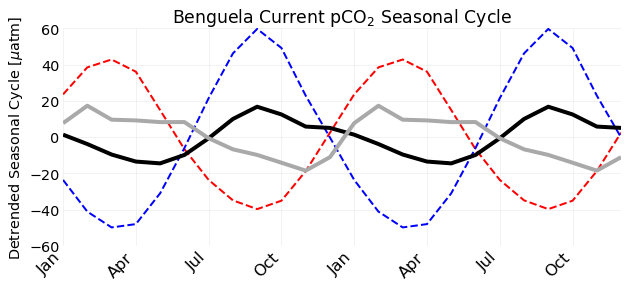

In [52]:
title = {'CalCS': 'California Current',
         'HumCS': 'Humboldt Current',
         'CanCS': 'Canary Current',
         'BenCS': 'Benguela Current'}

f, ax = plt.subplots(figsize=(10,4))

# Model plot
plot_cycle(T, color='r', linewidth=2, linestyle='--', 
           label='CESM-LE Thermal Effects')
plot_cycle(nonT, color='b', linewidth=2, linestyle='--', 
           label='CESM-LE Non-Thermal Effects')
plot_cycle(total, color='k', linewidth=4, label='CESM-LE Seasonal Cycle')

# SOM Seasonal Cycle
plot_cycle(som_pco2, linewidth=4, color='#a9a9a9', 
           label='SOM-FFN Seasonal Cycle')

# Plot aesthetics
ax.set_xlim([1, 24])
ax.set_xticks(np.arange(1, 25, 3))
labels = ['Jan', 'Apr', 'Jul', 'Oct']*2
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.set_xlabel('')

ax.set_ylim([-60, 60])
ax.set_ylabel('Detrended Seasonal Cycle [$\mu$atm]')

ax.set_title(title[EBC] + ' pCO$_{2}$ Seasonal Cycle')

# Legend
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.setp(plt.gca().get_legend().get_texts(), fontsize=14)


#et.vis.savefig(EBC + '_seasonal_cycle_decomposed', extension='.eps', dpi=300)